In [1]:
from time import process_time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rebound
import reboundx
%matplotlib inline

In [2]:
Degree_To_Rad = np.pi/180.
AU_To_Meter = 1.496e11

m_Sun = 1.99e30 # solar mass in [kg]
R_Sun = 6.957e8 # solar radius in [m]
m_J = 1.898e27 # Jupiter mass in [kg]
R_J = 7.1492e7 # Jupiter radius in [m]
a_J = 7.78479e8 # Jupiter semi-major axis in [m]
m_E = 5.9722e24 # Earth mass in [kg]
R_E = 6.371e6 # Earth radius in [m]


k1 = 0.8059 # m_star/m_Sun
m_Star = k1 * m_Sun
R_Star = k1 * R_Sun
R_sub = (k1**2) * 4 * R_Sun

k2 = m_E/m_J # m_planet/m_Jupiter
m_Planet = k2 * m_J

if k2 <= 0.41:
    R_Planet = R_E * (m_Planet/m_E)**(0.59) # low-mass planet; scale with Earth
else:
    R_Planet = R_J * k2**(-0.04) # massive planet; scale with Jupiter

k_ap = 10
a_Planet = k_ap * R_Sun

In [3]:
sim = rebound.Simulation()
sim.integrator = "ias15"
sim.G = 6.674e-11 # SI units
sim.dt = 1.e2 # Initial timestep in sec.
sim.N_active = 2 # Make it so dust particles don't interact with one another gravitationally

sim.add(m = m_Star, r = R_sub, hash = "Star")
sim.add(m = m_Planet, a = a_Planet, e = 0, r = R_Planet, hash = "Planet")
sim.move_to_com()

ps = sim.particles

sim.status()

---------------------------------
REBOUND version:     	3.17.3
REBOUND built on:    	Jun 26 2021 14:35:07
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	100.000000
---------------------------------
<rebound.particle.Particle object at 0x7fd5d8b6d3c0, m=1.603741e+30 x=-25907.201148448097 y=0.0 z=0.0 vx=0.0 vy=-0.46190059099305064 vz=0.0>
<rebound.particle.Particle object at 0x7fd5d8b6d540, m=5.9722e+24 x=6956974092.798852 y=0.0 z=0.0 vx=0.0 vy=124036.18694949702 vz=0.0>
---------------------------------


In [4]:
# set up reboundx and radiation force & PR-drag force

rebx = reboundx.Extras(sim)
rf = rebx.load_force("radiation_forces")
rebx.add_force(rf)
rf.params["c"] = 3.e8

In [5]:
ps["Star"].params["radiation_source"] = 1 # set 'Star' to be the source of radiation

In [6]:
# get beta

if k1 <= 0.43: luminosity = 3.827e+26 * (k1**2.3) # Watts
else: luminosity = 3.827e+26 * (k1**4) # 0.43<k1<2

grain_radius = 3.0 * 1e-6 # grain radius in [m]
density = 1000. # kg/m^3 = 1g/cc
Q_pr = 1.

beta = rebx.rad_calc_beta(sim.G, rf.params["c"], ps[0].m, luminosity, grain_radius, density, Q_pr)

print("beta = {0}".format(beta))

beta = 0.1000164742216322


In [7]:
# Add multiple dust grains with the same orbit
sim.add(a=3*a_Planet, e=0, inc=10*Degree_To_Rad, hash="p1")
sim.add(a=3*a_Planet, e=0.2, inc=10*Degree_To_Rad, hash="p2")
sim.add(a=3*a_Planet, e=0.4, inc=10*Degree_To_Rad, hash="p3")
sim.add(a=3*a_Planet, e=0.6, inc=10*Degree_To_Rad, hash="p4")

sim.status()

---------------------------------
REBOUND version:     	3.17.3
REBOUND built on:    	Jun 26 2021 14:35:07
Number of particles: 	6
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	100.000000
---------------------------------
<rebound.particle.Particle object at 0x7fd5d8b6d4c0, m=1.603741e+30 x=-25907.201148448097 y=0.0 z=0.0 vx=0.0 vy=-0.46190059099305064 vz=0.0>
<rebound.particle.Particle object at 0x7fd5d8b6d940, m=5.9722e+24 x=6956974092.798852 y=0.0 z=0.0 vx=0.0 vy=124036.18694949702 vz=0.0>
<rebound.particle.Particle object at 0x7fd5d8b6d4c0, m=0.0 x=20871000000.0 y=0.0 z=0.0 vx=0.0 vy=70524.63640871685 vz=12435.39620351132>
<rebound.particle.Particle object at 0x7fd5d8b6d940, m=0.0 x=16696800000.0 y=0.0 z=0.0 vx=0.0 vy=86374.68674833247 vz=15230.187723972926>
<rebound.particle.Particle object at 0x7fd5d8b6d4c0, m=0.0 x=12522600000.0 y=0.0 z=0.0 vx=0.0 vy=107728.16156739449 vz=18995.381466452367>
<rebound.particle.Particle object at 0x7

In [8]:
ps["p1"].params["beta"] = beta
ps["p2"].params["beta"] = beta
ps["p3"].params["beta"] = beta
ps["p4"].params["beta"] = beta

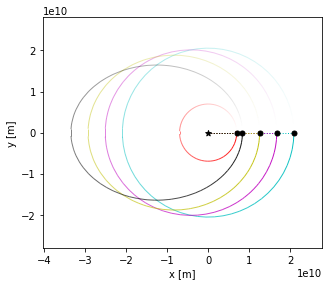

In [9]:
fig, ax = rebound.OrbitPlot(sim, unitlabel="[m]", color=True, periastron=True)

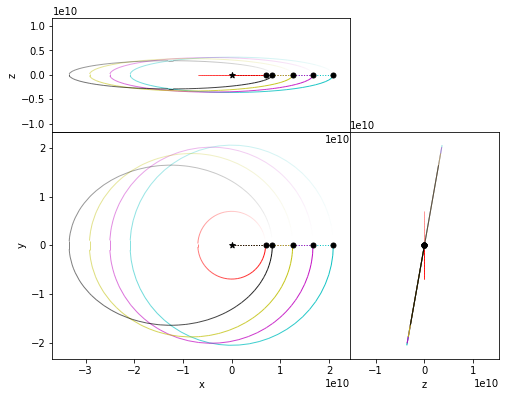

In [10]:
fig = rebound.OrbitPlot(sim, slices=0.5, color=True, periastron=True)


In [11]:
x_s, y_s, z_s = ps['Star'].x, ps['Star'].y, ps['Star'].z
vx_s, vy_s, vz_s = ps['Star'].vx, ps['Star'].vy, ps['Star'].vz
x_p, y_p, z_p = ps['Planet'].x, ps['Planet'].y, ps['Planet'].z
x_d, y_d, z_d = ps[2].x, ps[2].y, ps[2].z
vx_d, vy_d, vz_d = ps[2].vx, ps[2].vy, ps[2].vz
r_ds = np.sqrt((x_d-x_s)**2+(y_d-y_s)**2+(z_d-z_s)**2)
r_dp = np.sqrt((x_d-x_p)**2+(y_d-y_p)**2+(z_d-z_p)**2)
v_ds = np.sqrt((vx_d-vx_s)**2+(vy_d-vy_s)**2+(vz_d-vz_s)**2)

In [12]:
def get_jacobi_const(sim, ps_i):
    rstar = np.array(ps['Star'].xyz)
    rplanet = np.array(ps['Planet'].xyz)
    r = np.array(ps_i.xyz)
    v = np.array(ps_i.vxyz)
    
    KE = 0.5 * v@v # test particle kinetic energy
    mu1 = sim.G * ps['Star'].m
    mu2 = sim.G * ps['Planet'].m
    r1 = r-rstar
    r2 = r-rplanet
    PE = -mu1/np.sqrt(r1@r1) - mu2/np.sqrt(r2@r2) # test particle potential energy
    
    lz = np.cross(r,v)[-1] # component of the test particle's specific angular momentum aligned with planet's orbit normal
    
    CJ = 2 * ps['Planet'].n * lz - 2 * (KE + PE) # jacobi constant
    return CJ


In [13]:
start = process_time()

yr = 365*24*3600 # s

Noutput = 2200
times = np.linspace(0, 5.e4*yr, Noutput)

e1, a_d1, resonant_angle1 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
e2, a_d2, resonant_angle2 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
e3, a_d3, resonant_angle3 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
e4, a_d4, resonant_angle4 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
CJ1, CJ2, CJ3, CJ4 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput) # Jacobi constant
# C_j1, C_j2, C_j3, C_j4 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput) # Jacobi constant


for i, time in enumerate(times):
    sim.integrate(time)
    e1[i], a_d1[i] = ps["p1"].calculate_orbit().e, ps["p1"].calculate_orbit().a
    e2[i], a_d2[i] = ps["p2"].calculate_orbit().e, ps["p2"].calculate_orbit().a
    e3[i], a_d3[i] = ps["p3"].calculate_orbit().e, ps["p3"].calculate_orbit().a
    e4[i], a_d4[i] = ps["p4"].calculate_orbit().e, ps["p4"].calculate_orbit().a
    resonant_angle1[i] = 2*ps["p1"].l -  ps['Planet'].l - ps['p1'].pomega
    resonant_angle2[i] = 2*ps["p2"].l -  ps['Planet'].l - ps['p2'].pomega
    resonant_angle3[i] = 2*ps["p3"].l -  ps['Planet'].l - ps['p3'].pomega
    resonant_angle4[i] = 2*ps["p4"].l -  ps['Planet'].l - ps['p4'].pomega
    CJ1[i] = get_jacobi_const(sim, ps['p1'])
    CJ2[i] = get_jacobi_const(sim, ps['p2'])
    CJ3[i] = get_jacobi_const(sim, ps['p3'])
    CJ4[i] = get_jacobi_const(sim, ps['p4'])
#     C_j1[i] = -2/(ps['Planet'].v**2) * (0.5*v_ds**2 - sim.G*m_Sun*(1-ps["p1"].params["beta"])/r_ds - sim.G*m_J/r_dp - ps['Planet'].n*((x_d-x_s)*(vy_d-vy_s)-(y_d-y_s)*(vx_d-vx_s)))
                                        
end = process_time()
print("Running time: %s Seconds"%(end-start))  

/Users/minliqiu/opt/anaconda3/lib/python3.8/site-packages/rebound/simulation.py:712: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


Running time: 2258.8807380000003 Seconds


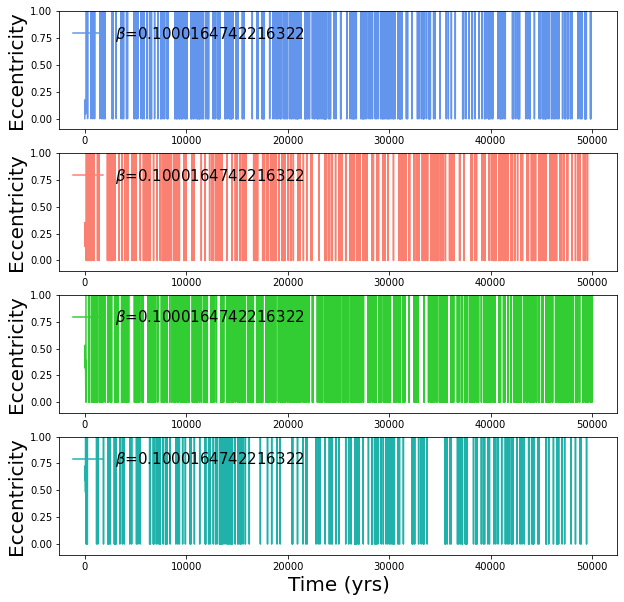

In [21]:

fig, ax = plt.subplots(4, 1, figsize=(10,10))

# ax[0].set_title(r"$\beta$={}".format(ps["p1"].params["beta"]))
ax[0].set_ylabel('Eccentricity', fontsize=20)
ax[0].set_ylim([-0.1, 1])
ax[0].plot(times/yr, e1, color = 'cornflowerblue', label=r"$\beta$={}".format(ps["p1"].params["beta"]))
ax[0].legend(frameon=False, loc='upper left', fontsize=15)

# ax[1].set_title(r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[1].set_ylabel('Eccentricity', fontsize=20)
ax[1].set_ylim([-0.1, 1])
ax[1].plot(times/yr, e2, color = 'salmon', label=r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[1].legend(frameon=False, loc='upper left', fontsize=15)

# ax[2].set_title(r"$\beta$={}".format(ps["p3"].params["beta"]))
ax[2].set_ylabel('Eccentricity', fontsize=20)
ax[2].set_ylim([-0.1, 1])
ax[2].plot(times/yr, e3, color = 'limegreen', label=r"$\beta$={}".format(ps["p3"].params["beta"]))
ax[2].legend(frameon=False, loc='upper left', fontsize=15)

# ax[3].set_title(r"$\beta$={}".format(ps["p4"].params["beta"]))
ax[3].set_xlabel('Time (yrs)', fontsize=20)
ax[3].set_ylabel('Eccentricity', fontsize=20)
ax[3].set_ylim([-0.1, 1])
ax[3].plot(times/yr, e4, color = 'lightseagreen', label=r"$\beta$={}".format(ps["p4"].params["beta"]))
ax[3].legend(frameon=False, loc='upper left', fontsize=15)




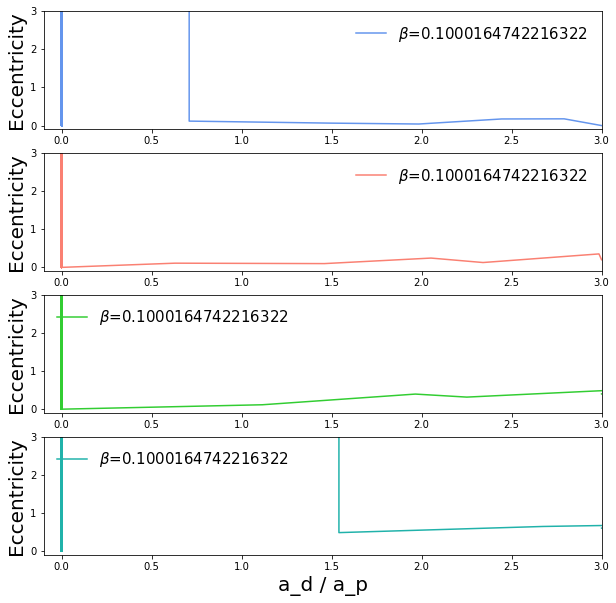

In [15]:

fig, ax = plt.subplots(4, 1, figsize=(10,10))

# ax[0].set_title(r"$\beta$={}".format(ps["p1"].params["beta"]))
ax[0].set_ylabel('Eccentricity', fontsize=20)
ax[0].set_xlim([-0.1, 3])
ax[0].set_ylim([-0.1, 3])
ax[0].plot(np.abs(a_d1)/a_Planet, e1, color = 'cornflowerblue', label=r"$\beta$={}".format(ps["p1"].params["beta"]))
ax[0].legend(frameon=False, loc='upper right', fontsize=15)

# ax[1].set_title(r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[1].set_ylabel('Eccentricity', fontsize=20)
ax[1].set_xlim([-0.1, 3])
ax[1].set_ylim([-0.1, 3])
ax[1].plot(np.abs(a_d2)/a_Planet, e2, color = 'salmon', label=r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[1].legend(frameon=False, loc='upper right', fontsize=15)

# ax[2].set_title(r"$\beta$={}".format(ps["p3"].params["beta"]))
ax[2].set_ylabel('Eccentricity', fontsize=20)
ax[2].set_xlim([-0.1, 3])
ax[2].set_ylim([-0.1, 3])
ax[2].plot(np.abs(a_d3)/a_Planet, e3, color = 'limegreen', label=r"$\beta$={}".format(ps["p3"].params["beta"]))
ax[2].legend(frameon=False, loc='upper left', fontsize=15)

# ax[3].set_title(r"$\beta$={}".format(ps["p4"].params["beta"]))
ax[3].set_xlabel(r"a_d / a_p", fontsize=20)
ax[3].set_ylabel('Eccentricity', fontsize=20)
ax[3].set_xlim([-0.1, 3])
ax[3].set_ylim([-0.1, 3])
ax[3].plot(np.abs(a_d4)/a_Planet, e4, color = 'lightseagreen', label=r"$\beta$={}".format(ps["p4"].params["beta"]))
ax[3].legend(frameon=False, loc='upper left', fontsize=15)





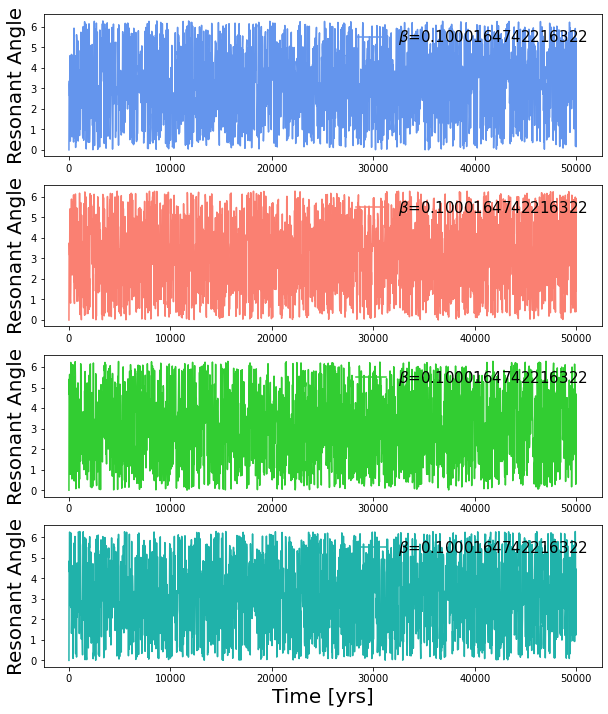

In [18]:

fig, ax = plt.subplots(4, 1, figsize=(10,12))

# ax[0].set_title(r"$\beta$={}".format(ps["p1"].params["beta"]))
ax[0].set_ylabel('Resonant Angle', fontsize=20)
ax[0].plot(times/yr, (resonant_angle1)%(2*np.pi), color = 'cornflowerblue', label=r"$\beta$={}".format(ps["p1"].params["beta"]))
ax[0].legend(frameon=False, loc='upper right', fontsize=15)

# ax[1].set_title(r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[1].set_ylabel('Resonant Angle', fontsize=20)
ax[1].plot(times/yr, (resonant_angle2)%(2*np.pi), color = 'salmon', label=r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[1].legend(frameon=False, loc='upper right', fontsize=15)

# ax[2].set_title(r"$\beta$={}".format(ps["p3"].params["beta"]))
ax[2].set_ylabel('Resonant Angle', fontsize=20)
ax[2].plot(times/yr, (resonant_angle3)%(2*np.pi), color = 'limegreen', label=r"$\beta$={}".format(ps["p3"].params["beta"]))
ax[2].legend(frameon=False, loc='upper right', fontsize=15)

# ax[3].set_title(r"$\beta$={}".format(ps["p4"].params["beta"]))
ax[3].set_xlabel('Time [yrs]', fontsize=20)
ax[3].set_ylabel('Resonant Angle', fontsize=20)
ax[3].plot(times/yr, (resonant_angle4)%(2*np.pi), color = 'lightseagreen', label=r"$\beta$={}".format(ps["p4"].params["beta"]))
ax[3].legend(frameon=False, loc='upper right', fontsize=15)



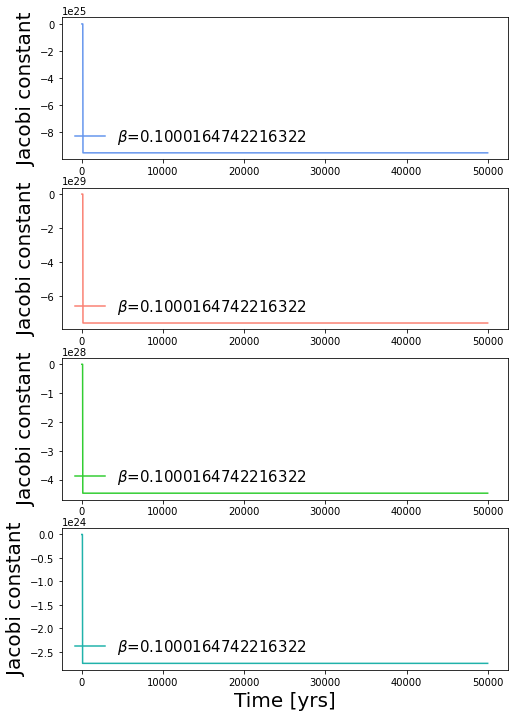

In [20]:
fig, ax = plt.subplots(4, 1, figsize=(8,12))

# ax[0].set_title(r"$\beta$={}".format(ps["p1"].params["beta"]))
ax[0].set_ylabel('Jacobi constant', fontsize=20)
# ax[0].set_ylim([2.5, 4])
ax[0].plot(times/yr, CJ1, color = 'cornflowerblue', label=r"$\beta$={}".format(ps["p1"].params["beta"]))
ax[0].legend(frameon=False, loc='lower left', fontsize=15)

# ax[1].set_title(r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[1].set_ylabel('Jacobi constant', fontsize=20)
ax[1].plot(times/yr, CJ2, color = 'salmon', label=r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[1].legend(frameon=False, loc='lower left', fontsize=15)

# ax[1].set_title(r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[2].set_ylabel('Jacobi constant', fontsize=20)
ax[2].plot(times/yr, CJ3, color = 'limegreen', label=r"$\beta$={}".format(ps["p3"].params["beta"]))
ax[2].legend(frameon=False, loc='lower left', fontsize=15)

# ax[1].set_title(r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[3].set_xlabel('Time [yrs]', fontsize=20)
ax[3].set_ylabel('Jacobi constant', fontsize=20)
ax[3].plot(times/yr, CJ4, color = 'lightseagreen', label=r"$\beta$={}".format(ps["p4"].params["beta"]))
ax[3].legend(frameon=False, loc='lower left', fontsize=15)